# Use the 🤗 transformers-native implementation of ColPali

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/use_transformers_native_colpali.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1869300356708262156)

[![Hugging Face](https://img.shields.io/badge/ColPali_hf_transformers_documentation-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/docs/transformers/main/en/model_doc/colpali)

## Introduction

With our new model *ColPali*, we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. Using ColPali removes the need for potentially complex and brittle layout recognition and OCR pipelines with a single model that can take into account both the textual and visual content (layout, charts, ...) of a document. ColPali is also highly interpretable: similarity maps can be obtained between patches and query tokens.

![ColPali Architecture](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/architecture/colpali_architecture.jpeg?raw=true)

This offers a more comprehensive understanding of documents and enables more efficient and accurate retrieval.

The following notebook guides you through using the native ColPali model implementation from `transformers` 🤗 for inference, scoring, and interpretability. While there are a few minor differences in the API, all the core functionalities are identical to the original implementation from `colpali-engine==0.3.x`.

### Hardware Requirements 🛠️

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on a M2 Pro MacBook).

In [ ]:
# For Part 1 about inference:
!pip install -q -U accelerate huggingface_hub torch transformers pillow

# For Part 2 about similarity maps:
# Use --no-deps to avoid version conflict with transformers.
!pip install -q --no-deps "colpali-engine[interpretability]>=0.3.2,<0.4.0"
!pip install -q -U einops matplotlib seaborn

^C
ERROR: Operation cancelled by user


## Part 1: Run inference with ColPali 🚀

### Login to a 🤗 HuggingFace account

Because ColPali uses the PaliGemma (Gemma-licensed) as its VLM backbone, you will have to login to a HuggingFace account that has accepted the terms and conditions of [`google/paligemma-3b-mix-448`](https://huggingface.co/google/paligemma-3b-mix-448).

In [ ]:
import os
token = os.getenv("HF_TOKEN")
# または
from huggingface_hub import login
login() 

### First, a few imports! ✨

In [ ]:
from io import BytesIO
from typing import List

import requests
import torch
from IPython.display import display
from PIL import Image
from transformers import ColPaliForRetrieval, ColPaliProcessor


def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

### Load the ColPali model and processor 🏎️

In this cookbook, we will use the [`vidore/colpali-v1.3-hf`](https://huggingface.co/vidore/colqwen2-v1.0-hf) checkpoint. Click on the link to read the model card! 📖

In [ ]:
model_name = "vidore/colpali-v1.3-hf"

model = ColPaliForRetrieval.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Image and query inputs 📄

Let's use 2 query-image pairs showcased in the [ColPali paper](https://arxiv.org/abs/2407.01449) as examples.

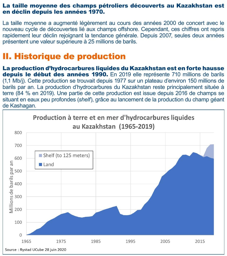

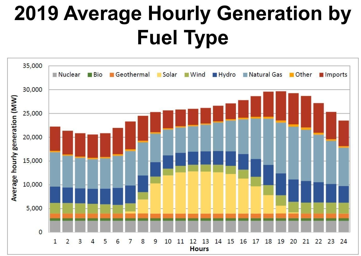

In [ ]:
# Load the image and query inputs
urls: List[str] = [
    "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/shift_kazakhstan.jpg?raw=true",
    "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/energy_electricity_generation.jpg?raw=true",
]
images: List[Image.Image] = [load_image_from_url(url) for url in urls]

queries: List[str] = [
    "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?",
    "Which hour of the day had the highest overall electricity generation in 2019?",
]

# Preview the input images
for image in images:
    display(scale_image(image, 256))

### Preprocess and embed the queries and the images 🧩

Now let's generate the embeddings for our images and queries. Note how ColPali's embeddings—unlike regular dense embeddings—are multi-vector, i.e., they are 2-dimensional.

More importantly, they are used within in the late interaction paradigm, making the representations fine-grained, rich, and efficient at retrieval time. Read this awesome [post](https://x.com/lateinteraction/status/1894696983077785980) from Omar Khattab for why late interaction paradigm is such a game-changer! 🧵

In [ ]:
# Preprocess inputs
batch_images = processor(images=images).to(model.device)
batch_queries = processor(text=queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings  # (batch_size, seq_len, embedding_dim)
    query_embeddings = model(**batch_queries).embeddings  # (batch_size, seq_len, embedding_dim)

Now what to do with these fresh embeddings? 🤔 Two options:

1. Use them as-is for retrieval using the built-in scoring `processor.score_retrieval` method (see next subsection). Mostly for testing and debugging.
2. Upload them to a vector store for production use.

All popular vector databases now support multi-vector embeddings, including:

- Vespa: https://blog.vespa.ai/scaling-colpali-to-billions/
- Qdrant: https://qdrant.tech/blog/qdrant-colpali/
- Milvus: https://milvus.io/docs/use_ColPali_with_milvus.md
- Elastic Search: https://www.elastic.co/search-labs/blog/elastiacsearch-colpali-document-search
- Weaviate: https://weaviate.io/developers/weaviate/tutorials/multi-vector-embeddings

### Score the queries against the images ✅

Now let's score all the query-image pairs using the late interaction similarity. Here's an amazing visual definition crafted by [Leonie Monigatti](https://x.com/helloiamleonie/status/1844030115237200336) for those who need a recap! 👀

<img src="https://pbs.twimg.com/media/GZdPne0XQAAd-5H?format=jpg&name=large" style="zoom:40%;" />

You should obtain a score matrix where the maximum scores are on the diagonal. This means the model has retrieved the correct image for each query. 🙌🏼

In [ ]:
scores = processor.score_retrieval(query_embeddings, image_embeddings)  # (n_queries, n_images)

scores

tensor([[23.1250,  9.1875],
        [12.7500, 22.8750]], dtype=torch.bfloat16)

## Part 2: Generate similarity maps 🗺️

By superimposing the late interaction similarity heatmap on top of the original image, we can visualize the
most salient image patches with respect to each term of the query, yielding interpretable insights
into ColPali's focus zones. 📍 We call this a *similarity map*.

This section will show you how to generate similarity maps for a given query and image pair. Keep your 👀 peeled!

### Imports + a few more utils! 🔧

In [ ]:
import pprint
from typing import Tuple

import matplotlib.pyplot as plt
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from transformers import BatchFeature, ProcessorMixin


def get_n_patches(processor: ProcessorMixin, patch_size: int) -> Tuple[int, int]:
    """
    Get the number of patches created by the processor along each dimension of the image.
    """
    n_patches_x = processor.image_processor.size["width"] // patch_size
    n_patches_y = processor.image_processor.size["height"] // patch_size
    return n_patches_x, n_patches_y


def get_image_mask(processor: ProcessorMixin, batch_images: BatchFeature) -> torch.Tensor:
    """
    Get a tensor mask that identifies the image tokens in the batch.
    """
    return batch_images.input_ids == processor.image_token_id

### Get the per-token similarity maps

In [ ]:
# Get the number of patches and the image mask for each image of the batch
batched_n_patches: List[Tuple[int, int]] = []  # [(n_patches_x, n_patches_y), ...]

for image in images:
    n_patches = get_n_patches(
        processor=processor,
        patch_size=model.vlm.vision_tower.config.patch_size,
    )
    batched_n_patches.append(n_patches)

image_mask = get_image_mask(processor=processor, batch_images=batch_images)

# Batch-compute the similarity maps
# NOTE: Each similarity map is 3D tensor of shape (query_length, n_patches_x, n_patches_y).
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=batched_n_patches,
    image_mask=image_mask,
)

### Show the possible tokens to analyze

In [ ]:
import pprint # もし前のセルでインポートしていない場合のために記載

# While all similarity maps are computed, we will only visualize the idx-th one
idx = 0
similarity_maps = batched_similarity_maps[idx]  # (query_length, n_patches_x, n_patches_y)

# Remove the padding tokens and the query augmentation tokens
# 修正箇所: ここでデコードして文字列にします
query_content = processor.decode(batch_queries.input_ids[idx])

# 修正箇所: すでに文字列になっているため、再度 decode せずに直接 replace を行います
query_content = query_content.replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()

# Retokenize the cleaned query
query_tokens = processor.tokenizer.tokenize(query_content)

# Use this cell output to choose a token using its index
pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁Quelle',
 4: '▁partie',
 5: '▁de',
 6: '▁la',
 7: '▁production',
 8: '▁p',
 9: 'étro',
 10: 'lière',
 11: '▁du',
 12: '▁Kazakhstan',
 13: '▁provi',
 14: 'ent',
 15: '▁de',
 16: '▁champs',
 17: '▁en',
 18: '▁mer',
 19: '▁?'}


### Select the query token of interest and visualize the associated similarity map

Selected token: `▁Kazakhstan`


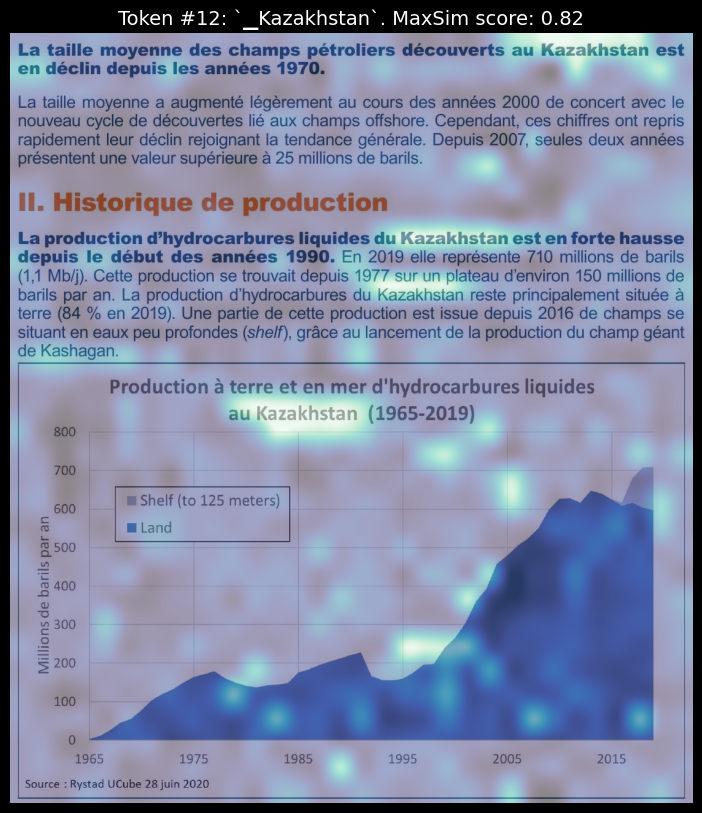

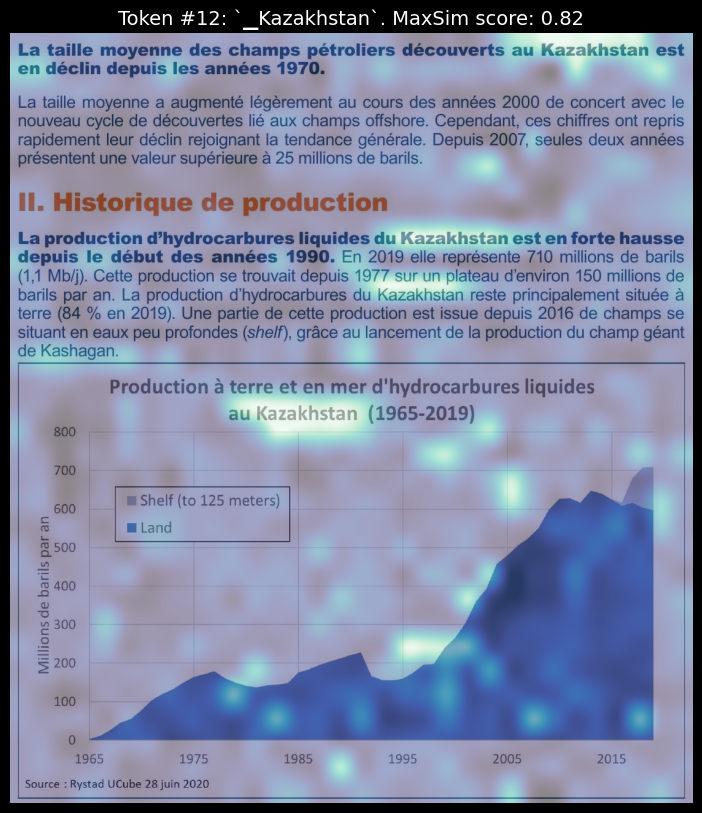

In [ ]:
# Choose a token using its index
token_idx = 12  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

# 修正箇所: image 変数ではなく、images[idx] を使用します
target_image = images[idx]

fig, ax = plot_similarity_map(
    image=target_image,          # <--- ここを修正しました
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

The brighter the patch, the higher similarity score it has with the selected token. In particular, similarity maps exhibit OCR capabilities and chart understanding of the ColPali model. 🧠

### Generate and save similarity maps for all query tokens

You can use the higher-level function `generate_similarity_maps` to generate similarity maps for all query tokens.

In [ ]:
plots = plot_all_similarity_maps(
    image=images[idx],
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")

Similarity map for token `<bos>` saved at `similarity_map_0.png`
Similarity map for token `Question` saved at `similarity_map_1.png`
Similarity map for token `:` saved at `similarity_map_2.png`
Similarity map for token `▁Quelle` saved at `similarity_map_3.png`
Similarity map for token `▁partie` saved at `similarity_map_4.png`
Similarity map for token `▁de` saved at `similarity_map_5.png`
Similarity map for token `▁la` saved at `similarity_map_6.png`
Similarity map for token `▁production` saved at `similarity_map_7.png`
Similarity map for token `▁p` saved at `similarity_map_8.png`
Similarity map for token `étro` saved at `similarity_map_9.png`
Similarity map for token `lière` saved at `similarity_map_10.png`
Similarity map for token `▁du` saved at `similarity_map_11.png`
Similarity map for token `▁Kazakhstan` saved at `similarity_map_12.png`
Similarity map for token `▁provi` saved at `similarity_map_13.png`
Similarity map for token `ent` saved at `similarity_map_14.png`
Similarity map f